In [7]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

Generating the product data:
we can track the number of sales per day. Dealing with count data. use a poisson distribution to model sales per day. with lambda being the average sales per day.
To get over the independence between days, we can use conditional independence. we can introduce a changepoint, after a certain day the average rate (lambda) can be higher or lower. 

one changepoints, two lambda values.
1st changepoint - viral point.
(maybe 2nd changepoint - the crash/fall off.)

We can use a poisson distribution to model sales data (non negative whole numbers)
lambda = rate = mean sales

We can use PYMC mcmc to model
calculating posterior distribution for our Lambda, and tau is hard
we can use MCMC, explore all possibilities using markov chain, samples to predict the shape our posterior distribution

2 Kernels:
kernel for lambda: normal distribution centered at current lambda
kernel for tau: uniform distibution 

initial lambda value is sampled from the prior distribution the exponential. guarantees we pick a valid starting number
initial tau sampled from discrete uniform

posterior = likelihood x prior

we can calculate the prior of each day sale using each distribution (exp and discrete unif). f(x) = ae^-ax and 1/N so prior = prior of lambda * prior of discrete
likelihood (give the rates what the prob of seeing this sale). p(k|lambda,tau). we can calculate the poisson probability of each with the formula (lambda^k*e^-lambda)/k!




In [8]:
def run_model_for_day(day_t, all_sales_data):
    
    observed_data = all_sales_data[:day_t]
    
    with pm.Model() as model:
        
        alpha = 1.0 / (observed_data.mean() + 0.01)
        
        lambda_1 = pm.Exponential("lambda_1", alpha)
        lambda_2 = pm.Exponential("lambda_2", alpha)
        
    
        tau = pm.DiscreteUniform("tau", lower=0, upper=day_t)
        
        
        idx = np.arange(day_t)
        lambda_t = pm.math.switch(idx < tau, lambda_1, lambda_2)
        
        
        observation = pm.Poisson("obs", mu=lambda_t, observed=observed_data)
        
        idata = pm.sample(1000, tune=1000, progressbar=False)
        
    return idata

In [9]:
df = pd.read_csv("sales_data_sample.csv", encoding='ISO-8859-1')
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])


weekly_sales = df.set_index('ORDERDATE').resample('W')['QUANTITYORDERED'].sum()


sales_data = weekly_sales.values
days = np.arange(len(sales_data))

print(f"New Data Length: {len(sales_data)} weeks")



New Data Length: 126 weeks


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
c:\Users\zadeboye\AppData\Local\Programs\Python\Python313\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_s

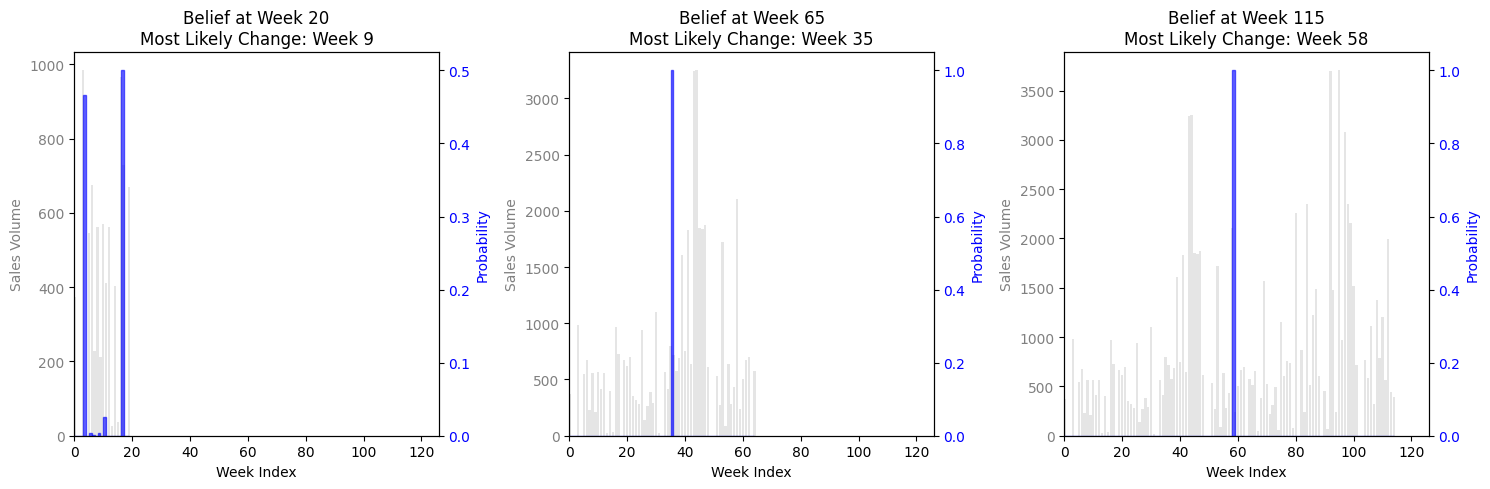

In [10]:

check_Weeks= [20, 65, 115]

plt.figure(figsize=(15, 5))

for i, week in enumerate(check_Weeks):
    
    result = run_model_for_day(week, sales_data)
    
    
    tau_samples = result.posterior["tau"].values.flatten()
    
    ax = plt.subplot(1, 3, i+1)
    
    ax.bar(days[:week], sales_data[:week], color='black', alpha=0.1, label='Sales Volume')
    ax.set_ylabel("Sales Volume", color='gray')
    ax.tick_params(axis='y', labelcolor='gray')
    ax.set_xlim(0, len(sales_data)) 
    
    ax2 = ax.twinx()
    
    ax2.hist(tau_samples, bins=range(week), density=True, 
             color='blue', alpha=0.6, edgecolor='blue', label='Prob of Change')
    
    ax2.set_ylabel("Probability", color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim(0, None)
    
    mean_tau = int(tau_samples.mean())
    ax.set_title(f"Belief at Week {week}\nMost Likely Change: Week {mean_tau}")
    ax.set_xlabel("Week Index")

plt.tight_layout()
plt.show()